In [1]:
import numpy as np
import uproot
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py

In [2]:
f = open("temp_data/Bi.txt")

In [3]:
energy = []
crs = []

In [4]:
for line in f:
    energy.append(float(line[3:14]))
    crs.append(float(line[20:27]))

In [6]:
energy = np.array(energy) * 1e6
crs = np.array(crs)

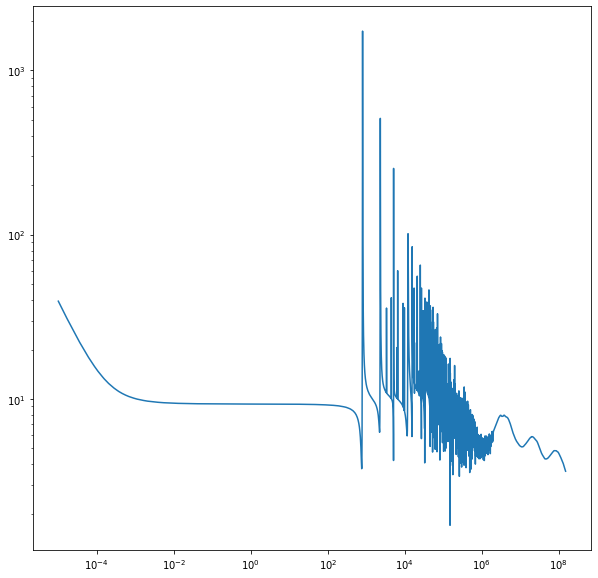

In [7]:
plt.figure(figsize=(10,10))
plt.plot(energy, crs)
plt.xscale('log')
plt.yscale('log')

(600.0, 1000.0)

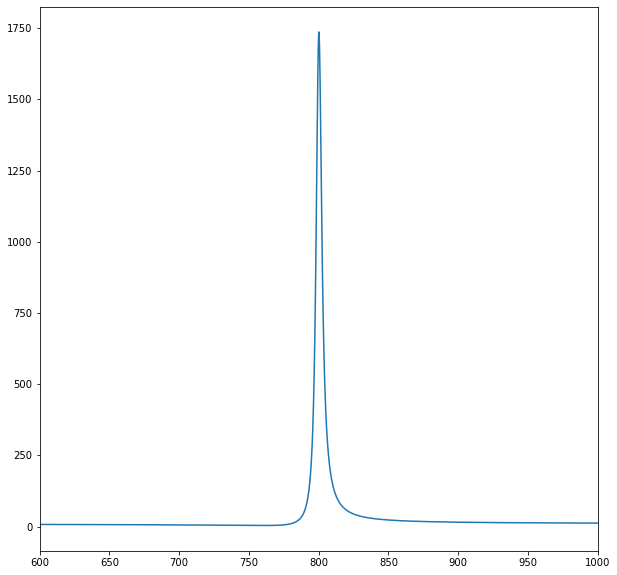

In [9]:
plt.figure(figsize=(10,10))
plt.plot(energy, crs)
plt.xlim(600,1000)

In [10]:
def xsec_to_ts(xsec, rho, d, m):
    return np.exp(-rho * d * xsec / m)

In [11]:
ts = xsec_to_ts(crs * 1e-28, 9747, 0.01, 3.47e-25)

(600.0, 1000.0)

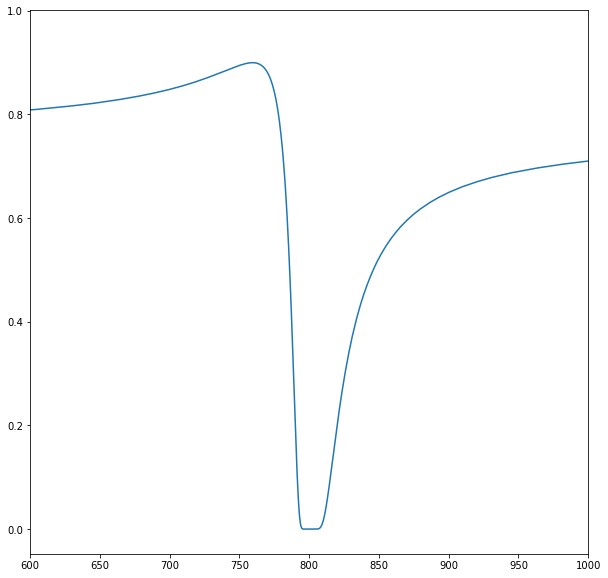

In [13]:
plt.figure(figsize=(10,10))
plt.plot(energy, ts)
plt.xlim(600,1000)

In [31]:
def search(arr, target):
    left = 0
    right = len(arr) - 1
    while left < right - 1:
        mid = left + (right - left) // 2
        if arr[mid] == target:
            return mid
        elif arr[mid] < target:
            left = mid
        else:
            right = mid
    return left

In [125]:
left = search(energy, 795.6)

In [126]:
right = search(energy, 806.02)

In [123]:
left = search(energy, 790)
right = search(energy, 815)

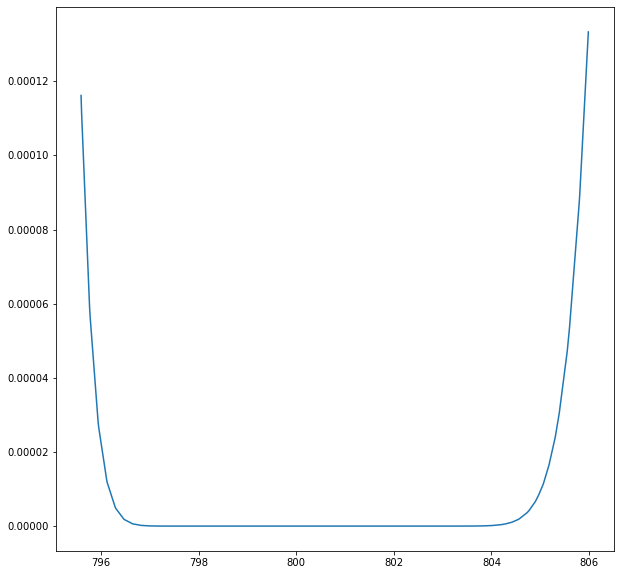

In [127]:
plt.figure(figsize=(10,10))
plt.plot(energy[left:right], ts[left:right])

In [143]:
BiIn = h5py.File("temp_data/BiIn.hdf5", "r")
BiOut = h5py.File("temp_data/BiOut.hdf5", "r")

In [144]:
amp_BiIn = BiIn['amp'][:]
en_BiIn = BiIn['energy'][:]
tof_BiIn = BiIn['tof'][:]
norm_BiIn = BiIn['norm'][0]
amp_BiOut = BiOut['amp'][:]
en_BiOut = BiOut['energy'][:]
tof_BiOut = BiOut['tof'][:]
norm_BiOut = BiOut['norm'][0]

In [105]:
en_BiIn_select = en_BiIn[(en_BiIn > 795.6) & (en_BiIn < 806.02) & (amp_BiIn > 4000)]

In [106]:
en_BiIn_select

array([805.02984827])

In [107]:
1 / norm_BiIn

7.995496690023161e-18

In [145]:
def tof_to_energy(tof, x, m, c):
    return m * (1 / np.sqrt(1 - x * x / c / c / tof / tof) - 1)

In [148]:
en_BiIn = tof_to_energy(tof_BiIn / 1e9, 182.24, 939.56542, 299792458) * 1e6
en_BiOut = tof_to_energy(tof_BiOut / 1e9, 182.24, 939.56542, 299792458) * 1e6

/var/folders/px/8t76vndx7w7gx0d_zvq9m_l40000gn/T/ipykernel_41169/2814557146.py:2: RuntimeWarning: invalid value encountered in sqrt
  return m * (1 / np.sqrt(1 - x * x / c / c / tof / tof) - 1)


In [130]:
en_BiIn_select = en_BiIn[(en_BiIn > 600) & (en_BiIn < 1000) & (amp_BiIn > 4000)]
en_BiOut_select = en_BiOut[(en_BiOut > 600) & (en_BiOut < 1000) & (amp_BiOut > 4000)]

In [131]:
from src.graph import graph
from src.transmission import transmission

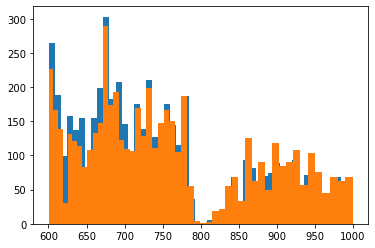

In [149]:
hist_BiIn, bins_BiIn, _, _ = graph(en_BiIn_select, 50)

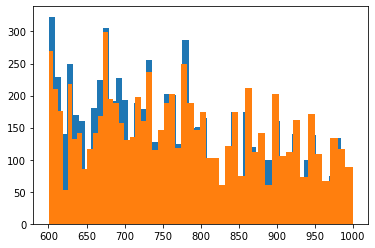

In [150]:
hist_BiOut, bins_BiOut, _, _ = graph(en_BiOut_select, 50)

In [134]:
x_en = (bins_BiIn[1:] + bins_BiIn[:-1]) / 2

In [137]:
y_crs = []
for x in x_en:
    index = search(energy, x)
    y = crs[index]
    y_crs.append(y)

In [138]:
y_ts = xsec_to_ts(np.array(y_crs) * 1e-28, 9747, 0.01, 3.47e-25)

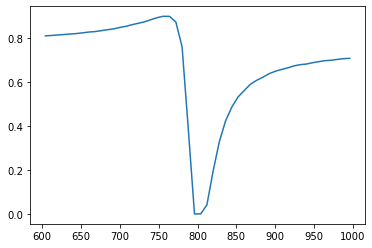

In [139]:
plt.plot(x_en, y_ts)

In [140]:
tr, tr_error = transmission(hist_BiIn / norm_BiIn, np.sqrt(hist_BiIn) / norm_BiIn, hist_BiOut / norm_BiOut, np.sqrt(hist_BiOut) / norm_BiOut)

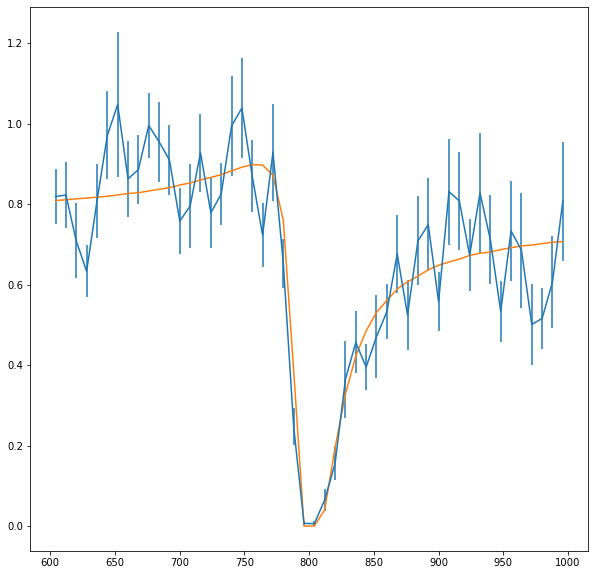

In [142]:
plt.figure(figsize=(10,10))
plt.errorbar(x_en, tr, yerr=tr_error)
plt.plot(x_en, y_ts)

In [159]:
def chi_sq(amp_BiIn, tof_BiIn, norm_BiIn, amp_BiOut, tof_BiOut, norm_BiOut, L, t, y_crs):
    en_BiIn = tof_to_energy(tof_BiIn / 1e9, L, 939.56542, 299792458) * 1e6
    en_BiOut = tof_to_energy(tof_BiOut / 1e9, L, 939.56542, 299792458) * 1e6
    en_BiIn_select = en_BiIn[(en_BiIn > 600) & (en_BiIn < 1000) & (amp_BiIn > 4000)]
    en_BiOut_select = en_BiOut[(en_BiOut > 600) & (en_BiOut < 1000) & (amp_BiOut > 4000)]
    hist_BiIn, bins_BiIn, _, _ = graph(en_BiIn_select, 50)
    hist_BiOut, bins_BiOut, _, _ = graph(en_BiOut_select, 50)
    y_ts = xsec_to_ts(np.array(y_crs) * 1e-28, 9747, t, 3.47e-25)
    tr, tr_error = transmission(hist_BiIn / norm_BiIn, np.sqrt(hist_BiIn) / norm_BiIn, hist_BiOut / norm_BiOut, np.sqrt(hist_BiOut) / norm_BiOut)
    r = y_ts - tr
    tr_error[tr_error < 1] = 0.7
    chi_sq = np.sum((r / tr_error) ** 2)
    return chi_sq

/var/folders/px/8t76vndx7w7gx0d_zvq9m_l40000gn/T/ipykernel_41169/2814557146.py:2: RuntimeWarning: invalid value encountered in sqrt
  return m * (1 / np.sqrt(1 - x * x / c / c / tof / tof) - 1)


1.1167396421005022

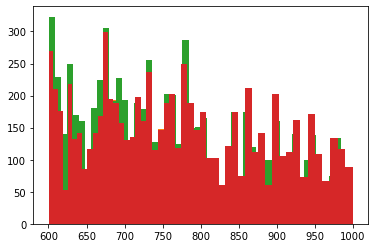

In [160]:
chi_sq(amp_BiIn, tof_BiIn, norm_BiIn, amp_BiOut, tof_BiOut, norm_BiOut, 182.24, 0.01, y_crs)

In [182]:
chi_sqs = []
Ls = np.linspace(181,184,301)

/var/folders/px/8t76vndx7w7gx0d_zvq9m_l40000gn/T/ipykernel_41169/2814557146.py:2: RuntimeWarning: invalid value encountered in sqrt
  return m * (1 / np.sqrt(1 - x * x / c / c / tof / tof) - 1)


181.0
181.01
181.02
181.03
181.04
181.05
181.06
181.07
181.08
181.09
181.1
181.11
181.12
181.13
181.14
181.15
181.16
181.17
181.18
181.19
181.2
181.21
181.22
181.23
181.24
181.25
181.26
181.27
181.28
181.29
181.3
181.31
181.32
181.33
181.34
181.35
181.36
181.37
181.38
181.39
181.4
181.41
181.42
181.43
181.44
181.45
181.46
181.47
181.48
181.49
181.5
181.51
181.52
181.53
181.54
181.55
181.56
181.57
181.58
181.59
181.6
181.61
181.62
181.63
181.64
181.65
181.66
181.67
181.68
181.69
181.7
181.71
181.72
181.73
181.74
181.75
181.76
181.77
181.78
181.79
181.8
181.81
181.82
181.83
181.84
181.85
181.86
181.87
181.88
181.89
181.9
181.91
181.92
181.93
181.94
181.95
181.96
181.97
181.98
181.99
182.0
182.01
182.02
182.03
182.04
182.05
182.06
182.07
182.08
182.09
182.1
182.11
182.12
182.13
182.14
182.15
182.16
182.17
182.18
182.19
182.2
182.21
182.22
182.23
182.24
182.25
182.26
182.27
182.28
182.29
182.3
182.31
182.32
182.33
182.34
182.35
182.36
182.37
182.38
182.39
182.4
182.41
182.42
182.43
182.44


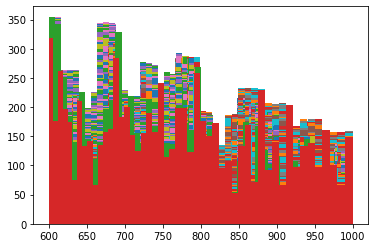

In [186]:
for L in Ls:
    chi_sqs.append(chi_sq(amp_BiIn, tof_BiIn, norm_BiIn, amp_BiOut, tof_BiOut, norm_BiOut, L, 0.01, y_crs))
    print(L)

In [187]:
chi_sqs

[2.635013962904686,
 2.6148724478814693,
 2.5612134499071963,
 2.562572111892246,
 2.497651949606118,
 2.4418519904900835,
 2.454074126470271,
 2.421806964133813,
 2.412239345749277,
 2.489124316131699,
 2.5258371747394994,
 2.629904303125262,
 2.576975188028443,
 2.5778663114256983,
 2.5761236460979,
 2.5865472289800193,
 2.5669307145688167,
 2.5877289470459264,
 2.5936070261707207,
 2.573053076704201,
 2.6907236773281307,
 2.332064201911135,
 2.3250964498216953,
 2.1532808227489415,
 2.169894444087117,
 2.1868119306220444,
 2.1904274950960576,
 2.20203201659268,
 2.207727890538987,
 2.104774026942123,
 2.0668466128947127,
 2.1027827439159226,
 2.1265392593629593,
 2.097989467869128,
 2.1080650057920898,
 2.0924162345883186,
 2.1485357926482416,
 2.1490143665887285,
 2.157786447180742,
 2.146252677810797,
 2.0202448577659475,
 2.0151917646590127,
 1.9749374060274625,
 1.9682427485288125,
 2.001203710942365,
 2.158974763313254,
 2.134701510974093,
 2.147921765947008,
 2.158103041632336

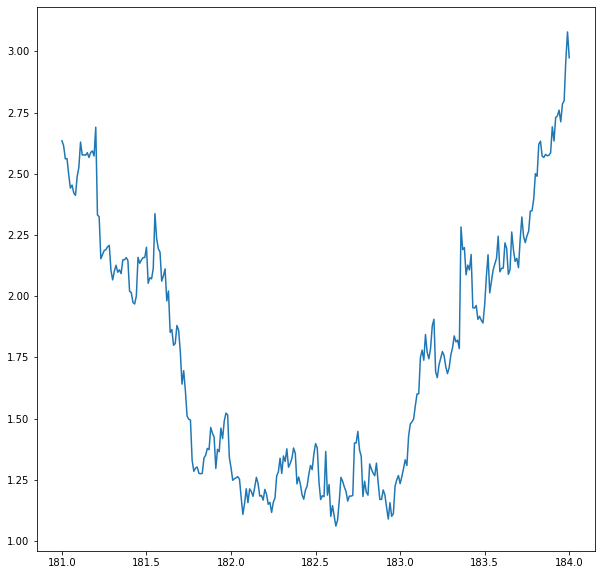

In [188]:
plt.figure(figsize=(10,10))
plt.plot(Ls, chi_sqs)

In [189]:
min_idx = 0
min_chi = 4
for i in range(301):
    if chi_sqs[i] < min_chi:
        min_chi = chi_sqs[i]
        min_idx = i

In [190]:
min_idx

162

In [191]:
min_chi

1.0608167141131009

In [192]:
Ls[162]

182.62

/var/folders/px/8t76vndx7w7gx0d_zvq9m_l40000gn/T/ipykernel_41169/2814557146.py:2: RuntimeWarning: invalid value encountered in sqrt
  return m * (1 / np.sqrt(1 - x * x / c / c / tof / tof) - 1)


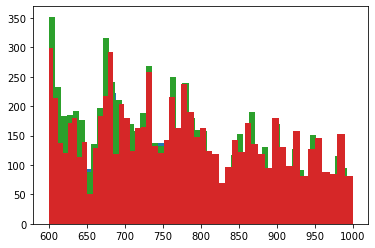

In [194]:
en_BiIn = tof_to_energy(tof_BiIn / 1e9, 182.62, 939.56542, 299792458) * 1e6
en_BiOut = tof_to_energy(tof_BiOut / 1e9, 182.62, 939.56542, 299792458) * 1e6
en_BiIn_select = en_BiIn[(en_BiIn > 600) & (en_BiIn < 1000) & (amp_BiIn > 4000)]
en_BiOut_select = en_BiOut[(en_BiOut > 600) & (en_BiOut < 1000) & (amp_BiOut > 4000)]
hist_BiIn, bins_BiIn, _, _ = graph(en_BiIn_select, 50)
hist_BiOut, bins_BiOut, _, _ = graph(en_BiOut_select, 50)
tr, tr_error = transmission(hist_BiIn / norm_BiIn, np.sqrt(hist_BiIn) / norm_BiIn, hist_BiOut / norm_BiOut, np.sqrt(hist_BiOut) / norm_BiOut)

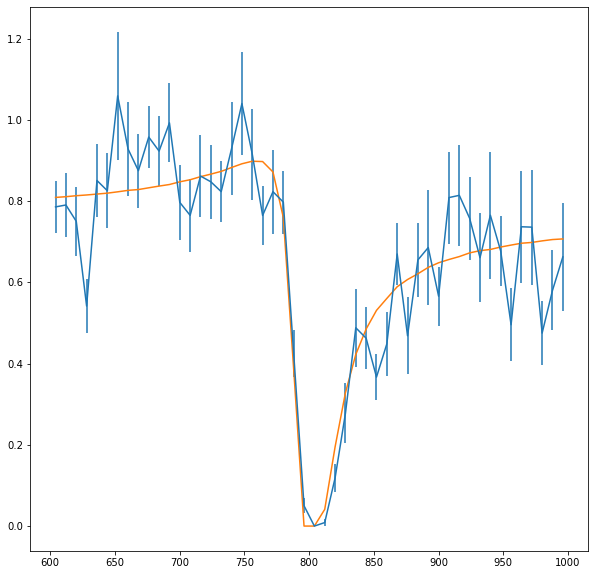

In [195]:
plt.figure(figsize=(10,10))
plt.errorbar(x_en, tr, yerr=tr_error)
plt.plot(x_en, y_ts)

In [5]:
import math

In [39]:
-np.log(0.1)

2.3025850929940455

In [4]:
-np.log(0.05)

2.995732273553991

In [12]:
def poisson(k, mu):
    return mu**k * np.exp(-mu) / math.factorial(k)

In [24]:
def poi_sum(low, high, mu):
    ret = 0
    for i in range(low, high + 1):
        ret += poisson(i, mu)
    return ret

In [31]:
poi_sum(0,4,2.44)

0.8990485264171251

In [38]:
poi_sum(0,6,3.09)

0.9617484957623851

In [37]:
poi_sum(1,1,0.11)

0.0985417548826181

In [42]:
poisson(0, 2.3)

0.10025884372280375

In [40]:
poisson(1, 0.105) 

0.09453407487155789

In [46]:
poisson(1, 3.89) + poisson(0, 3.89)

0.09997774212551513

In [45]:
poisson(0, 3.89)

0.020445346037937653

In [47]:
poisson(1, 3.89)

0.07953239608757748

In [48]:
poisson(1, 0.105)

0.09453407487155789

In [51]:
poisson(0, 0.105)

0.9003245225862656

In [52]:
1 - poisson(0, 0.105)

0.09967547741373439

In [53]:
0.3173/2

0.15865

In [54]:
def upper_sum(mu):
    return poisson(1, mu) + poisson(0, mu)

In [65]:
upper_sum(3)

0.19914827347145578

In [68]:
for i in np.linspace(3,3.5,51):
    print(str(i) + " " + str(upper_sum(i)))
#3.3 0.15859761982533205

3.0 0.19914827347145578
3.01 0.1976596318294533
3.02 0.1961808978152921
3.03 0.19471202164805318
3.04 0.1932529535565614
3.05 0.19180364378412074
3.06 0.19036404259315326
3.07 0.18893410026974528
3.08 0.18751376712810036
3.09 0.18610299351490223
3.1 0.18470172981358698
3.11 0.18330992644852834
3.12 0.1819275338891346
3.13 0.1805545026538614
3.14 0.17919078331413882
3.15 0.17783632649821676
3.16 0.17649108289492738
3.17 0.17515500325736794
3.18 0.17382803840650382
3.19 0.17251013923469383
3.2 0.1712012567091381
3.21 0.16990134187525113
3.22 0.16861034585995946
3.23 0.1673282198749266
3.24 0.16605491521970517
3.25 0.16479038328481854
3.26 0.16353457555477185
3.27 0.16228744361099431
3.2800000000000002 0.16104893913471413
3.29 0.15981901390976583
3.3 0.15859761982533205
3.31 0.15738470887862113
3.32 0.15618023317748056
3.33 0.15498414494294743
3.34 0.1537963965117381
3.35 0.15261694033867584
3.36 0.15144572899906014
3.37 0.15028271519097575
3.38 0.14912785173754511
3.39 0.1479810915891228

In [69]:
def lower_sum(mu):
    return 1 - poisson(0, mu)

In [72]:
lower_sum(0.2)

0.18126924692201818

In [73]:
lower_sum(0.1)

0.09516258196404048

In [75]:
for i in np.linspace(0.1,0.2,101):
    print(str(i) + " " + str(lower_sum(i)))
#0.173 0.15886238515537676

0.1 0.09516258196404048
0.101 0.09606696711413587
0.10200000000000001 0.09697044833112323
0.10300000000000001 0.09787302651848351
0.10400000000000001 0.09877470257879528
0.10500000000000001 0.09967547741373439
0.10600000000000001 0.10057535192407596
0.10700000000000001 0.1014743270096945
0.10800000000000001 0.10237240356956512
0.10900000000000001 0.10326958250176455
0.11 0.10416586470347178
0.111 0.10506125107096898
0.112 0.10595574249964279
0.113 0.10684933988398448
0.114 0.1077420441175917
0.115 0.10863385609316867
0.116 0.10952477670252736
0.117 0.11041480683658866
0.11800000000000001 0.11130394738538263
0.11900000000000001 0.1121921992380499
0.12000000000000001 0.11307956328284252
0.12100000000000001 0.11396604040712444
0.122 0.11485163149737287
0.123 0.1157363374391791
0.124 0.1166201591172491
0.125 0.11750309741540454
0.126 0.11838515321658394
0.127 0.11926632740284304
0.128 0.12014662085535621
0.129 0.12102603445441684
0.13 0.1219045690794387
0.131 0.12278222560895646
0.132 0.12